In [1]:
from __future__ import absolute_import, division, print_function

import pandas as pd
import numpy as np
import torch

# Load the Drive helper and mount
from google.colab import drive


drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
dataframe = pd.read_csv('./drive/MyDrive/security_data/CSV/Scenario-A/SelectedFeatures-10s-TOR-NonTOR.csv')

In [4]:
df = dataframe.drop(columns=['Source IP', ' Destination IP', 'Active Mean', ' Active Std', ' Active Max', ' Active Min', 'Idle Mean', ' Idle Std', ' Idle Max', ' Idle Min'])

In [5]:
def label_transfer(d):
  if d == 'TOR':
    return 1
  else:
    return 0

df.label = df.label.apply(lambda x: label_transfer(x))

df = df.replace([np.inf, -np.inf], np.nan)

df = df.dropna()

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

train, test = train_test_split(df, test_size=0.2)

train_x = train.values[:, :17] #returns a numpy array
train_y = train.label.to_numpy()
train_x = scaler.fit_transform(train_x)

test_x = test.values[:, :17] #returns a numpy array
test_y = test.label.to_numpy()
test_x = scaler.fit_transform(test_x)


In [7]:
train_X = torch.from_numpy(train_x).type(torch.FloatTensor)
train_Y = torch.from_numpy(train_y).type(torch.LongTensor)

test_X = torch.from_numpy(test_x).type(torch.FloatTensor)
test_Y = torch.from_numpy(test_y).type(torch.LongTensor)

In [8]:
import torch.nn as nn
import torch.nn.functional as F

class NaiveClassifier(nn.Module):
  def __init__(self, dropout=0.1):
    super(NaiveClassifier,self).__init__()
    #Our network consists of 3 layers. 1 input, 1 hidden and 1 output layer
    #This applies Linear transformation to input data. 
    HIDDEN_SIZE = 128
    self.fc1 = nn.Linear(17,HIDDEN_SIZE)
    self.fc2 = nn.Linear(HIDDEN_SIZE,int(HIDDEN_SIZE))
    self.fc3 = nn.Linear(int(HIDDEN_SIZE),int(HIDDEN_SIZE))
    self.fc4 = nn.Linear(int(HIDDEN_SIZE),int(HIDDEN_SIZE))
    self.fc5 = nn.Linear(int(HIDDEN_SIZE),int(HIDDEN_SIZE))
    self.fc6 = nn.Linear(int(HIDDEN_SIZE),int(HIDDEN_SIZE/8))
    #This applies linear transformation to produce output data
    self.fc7 = nn.Linear(int(HIDDEN_SIZE/8), 2)

  def forward(self,x):
    #Output of the first layer
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    x = F.relu(self.fc4(x))
    x = F.relu(self.fc5(x))
    x = F.relu(self.fc6(x))
    #This produces output
    x = self.fc7(x)
    return x
        
    #This function takes an input and predicts the class, (0 or 1)        
  def predict(self,x):
    #Apply sigmoid to output. 
    pred = F.sigmoid(self.forward(x))
    ans = []
    #Pick the class with maximum weight
    for t in pred:
      if t[0]>t[1]:
          ans.append(0)
      else:
          ans.append(1)
    return torch.tensor(ans)

In [9]:
import torch.optim

#Initialize the model        
model = NaiveClassifier()
#Define loss criterion
criterion = nn.CrossEntropyLoss()
#Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [10]:
#Number of epochs
epochs = 250
#List to store losses
losses = []
test_losses = []
for i in range(epochs):
  #Precit the output for Given input
  train_y_pred = model.forward(train_X)
  test_y_pred = model.forward(test_X)
  #Compute Cross entropy loss
  loss = criterion(train_y_pred, train_Y)
  test_lost = criterion(test_y_pred, test_Y)
  #Add loss to the list
  losses.append(loss.item())
  test_losses.append(test_lost.item())
  #Clear the previous gradients
  optimizer.zero_grad()
  #Compute gradients
  loss.backward()
  #Adjust weights
  optimizer.step()

  if (i % 21 == 0):
    print(i, loss.data, test_lost.data)

0 tensor(0.6700) tensor(0.6698)
21 tensor(0.2790) tensor(0.2774)
42 tensor(0.1780) tensor(0.1772)
63 tensor(0.1553) tensor(0.1569)
84 tensor(0.1213) tensor(0.1264)
105 tensor(0.1014) tensor(0.1069)
126 tensor(0.0896) tensor(0.0954)
147 tensor(0.0773) tensor(0.0843)
168 tensor(0.0848) tensor(0.0918)
189 tensor(0.0717) tensor(0.0778)
210 tensor(0.0626) tensor(0.0727)
231 tensor(0.0570) tensor(0.0698)


In [12]:
from sklearn import metrics
print(metrics.accuracy_score(model.predict(test_X),test_Y))
print(metrics.precision_score(model.predict(test_X),test_Y))
print(metrics.recall_score(model.predict(test_X),test_Y))
print(metrics.classification_report(model.predict(test_X), test_Y))

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


0.9752321981424149
0.8630050505050505
0.9199192462987887
              precision    recall  f1-score   support

           0       0.99      0.98      0.99     12080
           1       0.86      0.92      0.89      1486

    accuracy                           0.98     13566
   macro avg       0.93      0.95      0.94     13566
weighted avg       0.98      0.98      0.98     13566



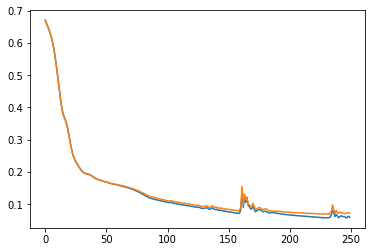

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(losses)
plt.plot(test_losses)
plt.show()

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


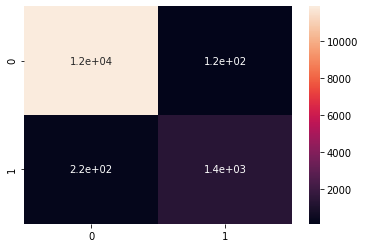

In [15]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(test_Y, model.predict(test_X))
sns.heatmap(cm, annot=True)

In [16]:
from sklearn.ensemble import RandomForestClassifier

regressor = RandomForestClassifier(n_estimators=20, random_state=0)
regressor.fit(train_x, train_y)
y_pred = regressor.predict(test_x)

In [17]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print(confusion_matrix(test_y, y_pred))
print(classification_report(test_y, y_pred))
print(accuracy_score(test_y, y_pred))

[[11736   246]
 [  269  1315]]
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     11982
           1       0.84      0.83      0.84      1584

    accuracy                           0.96     13566
   macro avg       0.91      0.90      0.91     13566
weighted avg       0.96      0.96      0.96     13566

0.9620374465575704


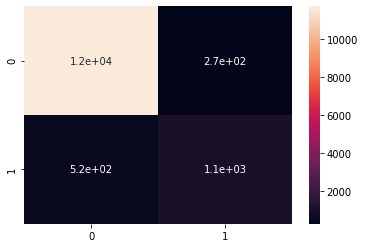

In [19]:
cm = confusion_matrix(test_y, y_pred)
sns.heatmap(cm, annot=True)

In [18]:
from sklearn.linear_model import SGDClassifier

regressor = SGDClassifier()
regressor.fit(train_x, train_y)
y_pred = regressor.predict(test_x)

print(confusion_matrix(test_y, y_pred))
print(classification_report(test_y, y_pred))
print(accuracy_score(test_y, y_pred))

[[11712   270]
 [  515  1069]]
              precision    recall  f1-score   support

           0       0.96      0.98      0.97     11982
           1       0.80      0.67      0.73      1584

    accuracy                           0.94     13566
   macro avg       0.88      0.83      0.85     13566
weighted avg       0.94      0.94      0.94     13566

0.9421347486362966
